In [738]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt 
import plotly.express as px
import altair as alt
from datetime import datetime, date, time, timedelta

# Clean Data

In [739]:
df_kc =  pd.read_csv("data/king_county_data.csv")
df_kc.head(2)

Unnamed: 0        date     price    house_id  id_x        id_y  bedrooms  \
0           0  2014-10-13  221900.0  7129300520     1  7129300520       3.0   
1           1  2014-12-09  538000.0  6414100192     2  6414100192       3.0   

   bathrooms  sqft_living  sqft_lot  ...  grade  sqft_above  sqft_basement  \
0       1.00       1180.0    5650.0  ...      7      1180.0            0.0   
1       2.25       2570.0    7242.0  ...      7      2170.0          400.0   

   yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
0      1955           0.0    98178  47.5112 -122.257         1340.0   
1      1951       19910.0    98125  47.7210 -122.319         1690.0   

   sqft_lot15  
0      5650.0  
1      7639.0  

[2 rows x 24 columns]

In [740]:
df_kc.drop(["Unnamed: 0", "id_x", "id_y"], axis=1, inplace=True)
df_kc.columns

Index(['date', 'price', 'house_id', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [741]:
#reorder columns
df_kc = df_kc[['house_id', 'date', 'price', 'bedrooms',
       'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view',
       'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built',
       'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15']]

In [742]:
df_kc.duplicated().sum()

np.int64(0)

In [743]:
df_kc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   house_id       21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  float64
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  float64
 6   sqft_lot       21597 non-null  float64
 7   floors         21597 non-null  float64
 8   waterfront     19206 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  float64
 13  sqft_basement  21145 non-null  float64
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17749 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [744]:
df_kc['date'] = pd.to_datetime(df_kc['date'], format='%Y-%m-%d')

In [745]:
df_kc['bedrooms'] = df_kc['bedrooms'].astype(int)
df_kc['bathrooms'] = df_kc['bathrooms'].astype(int)
df_kc['floors'] = df_kc['floors'].astype(int)
df_kc["condition"] = df_kc["condition"].astype(int)
df_kc['yr_renovated'] = df_kc['yr_renovated']/10 #Corrected error in data

In [746]:
df_kc['yr_renovated'] = df_kc['yr_renovated'].fillna(0).astype(int) 
df_kc['sqft_basement'] = df_kc['sqft_basement'].fillna(0).astype(int) # Assuming NaN == no basement
df_kc['waterfront'] = df_kc['waterfront'].fillna(2).astype(int) # Will save NaN as "2" just in case it's useful later, as I could double check that in a map if needed
df_kc['view'] = df_kc['view'].fillna(2).astype(int) # same for now, maybe I drop them later as there are only 63 nan

In [747]:
df_kc.isna().sum()

house_id         0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

# EDA


> **Goal**: 
> 
> Identify **undervalued properties** in **poor neighborhoods** with **high potential for resale value growth post-renovation**. 


## Housing Price Distribution

In [748]:
price_bins = [0, 100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000, 900000, 1000000]
price_labels = [f"{int(price_bins[i]/1000)}K-{int(price_bins[i+1]/1000)}K" for i in range(len(price_bins)-1)]
df_kc['price_range'] = pd.cut(df_kc['price'], bins=price_bins, labels=price_labels)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, '0K-100K'),
  Text(1, 0, '100K-200K'),
  Text(2, 0, '200K-300K'),
  Text(3, 0, '300K-400K'),
  Text(4, 0, '400K-500K'),
  Text(5, 0, '500K-600K'),
  Text(6, 0, '600K-700K'),
  Text(7, 0, '700K-800K'),
  Text(8, 0, '800K-900K'),
  Text(9, 0, '900K-1000K')])

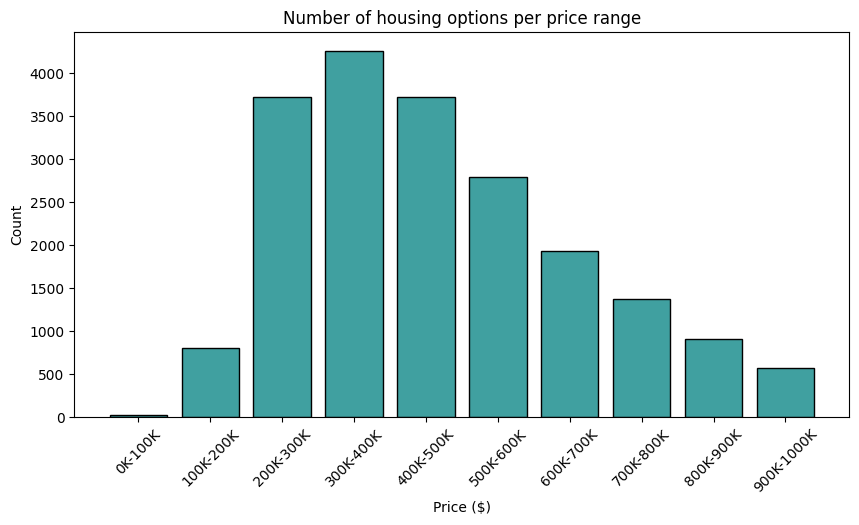

In [749]:
plt.figure(figsize=(10, 5))
sns.histplot(df_kc["price_range"], discrete=True, color = "teal", shrink=0.8)
plt.title("Number of housing options per price range")
plt.xlabel("Price ($)")
plt.xticks(rotation=45)

In [750]:
df_kc.columns

Index(['house_id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'price_range'],
      dtype='object')

In [751]:
df_kc["zipcode"].unique()

array([98178, 98125, 98028, 98136, 98074, 98053, 98003, 98198, 98146,
       98038, 98007, 98115, 98107, 98126, 98019, 98103, 98002, 98133,
       98040, 98092, 98030, 98119, 98112, 98052, 98027, 98117, 98058,
       98001, 98056, 98166, 98023, 98070, 98148, 98105, 98042, 98008,
       98059, 98122, 98144, 98004, 98005, 98034, 98075, 98116, 98010,
       98118, 98199, 98032, 98045, 98102, 98077, 98108, 98168, 98177,
       98065, 98029, 98006, 98109, 98022, 98033, 98155, 98024, 98011,
       98031, 98106, 98072, 98188, 98014, 98055, 98039])

In [752]:
#from an internet research (see documentation)

poor_seattle = [98108, 98106, 98125, 98115, 98118, 98144, 98126]
df_kc_target = df_kc[df_kc["zipcode"].isin(poor_seattle)]
df_kc_target["zipcode"].unique()

array([98125, 98115, 98126, 98144, 98118, 98108, 98106])

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, '0K-100K'),
  Text(1, 0, '100K-200K'),
  Text(2, 0, '200K-300K'),
  Text(3, 0, '300K-400K'),
  Text(4, 0, '400K-500K'),
  Text(5, 0, '500K-600K'),
  Text(6, 0, '600K-700K'),
  Text(7, 0, '700K-800K'),
  Text(8, 0, '800K-900K'),
  Text(9, 0, '900K-1000K')])

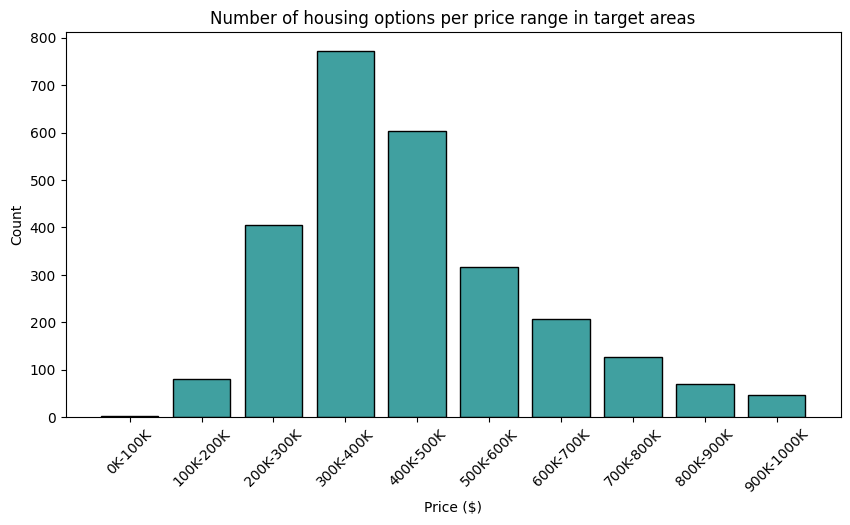

In [753]:
#interesting to see that actually poor neighbourhoods don't mean lower prices on houses
plt.figure(figsize=(10, 5))
sns.histplot(df_kc_target["price_range"], discrete=True, color = "teal", shrink=0.8)
plt.title("Number of housing options per price range in target areas")
plt.xlabel("Price ($)")
plt.xticks(rotation=45)

In [754]:
lats = df_kc.lat
lons = df_kc.long

# airports["scaled_size"] = airports["y_passengers"] / 80

fig = px.scatter_map(df_kc, 
                        lat="lat", 
                        lon="long",
                        hover_name="house_id",  # Main hover title
                        hover_data={"bedrooms": True, 
                                    "bathrooms": True, 
                                    "sqft_living": True,
                                    "price": True, 
                                    "lat": False,  # Hide latitude
                                    "long": False},  # Hide longitude
                        color_continuous_scale=px.colors.carto.Aggrnyl,
                        zoom=9)

# Add another scatter trace for poor Seattle houses
fig.add_trace(px.scatter_map(df_kc_target,
                                lat="lat",
                                lon="long",
                                hover_name="house_id",
                                hover_data={"bedrooms": True, 
                                            "bathrooms": True, 
                                            "sqft_living": True,
                                            "price": True,
                                            "lat": False, 
                                            "long": False},  
                                title="Housing in Seattle",
                                color_discrete_sequence=["brown"])  # Different color
             .data[0].update(name="Poor Seattle Zip Codes")  # Extract trace
)

# Update trace names for legend
fig.data[0].name = "All Houses"
fig.data[1].name = "Poor Seattle Zip Codes"


# Adjust the size reference to make small points more visible
fig.update_traces(marker=dict(sizeref=1000))  # Decrease this value to make points larger

fig.update_geos(fitbounds="locations")
fig.update_layout(height=600, width=1000)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":50,"t":50,"l":50,"b":50})

fig.update_layout(title="Housing in Seattle")

fig.show()


## Evaluate Outliers
> remove overly expensive housing options

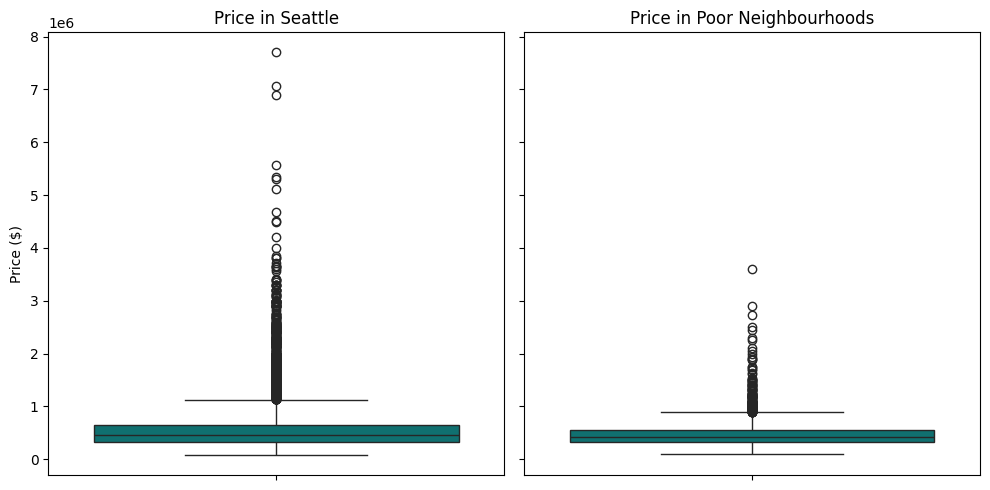

In [755]:
# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Plot the boxplots
sns.boxplot(y=df_kc["price"], ax=ax[0], color="teal")
sns.boxplot(y=df_kc_target["price"], ax=ax[1], color="teal")

# Set titles
ax[0].set_title('Price in Seattle')
ax[1].set_title('Price in Poor Neighbourhoods')

# Set y-axis label for both subplots
ax[0].set_ylabel("Price ($)")
ax[1].set_ylabel("Price ($)")

# Adjust layout to make it look nice
plt.ylabel("Price ($)")
plt.tight_layout()

# Show plot
plt.show()


In [756]:
stats = df_kc_target["price"].describe()
Q1 = stats['25%']
Q2 = stats['50%']
Q3 = stats['75%']
IQR = Q3 - Q1
lower_whisker = max(df_kc_target.price[df_kc_target.price >= (Q1 - 1.5 * IQR)].min(), df_kc_target.price.min())
upper_whisker = min(df_kc_target.price[df_kc_target.price <= (Q3 + 1.5 * IQR)].max(), df_kc_target.price.max())
print(f"Lower Whisker: {lower_whisker}")
print(f"Upper Whisker: {upper_whisker}")

Lower Whisker: 90000.0
Upper Whisker: 885000.0


In [757]:
#cleaned from outliers
df_kc_target = df_kc_target.query("price <= 885000")

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, '0K-100K'),
  Text(1, 0, '100K-200K'),
  Text(2, 0, '200K-300K'),
  Text(3, 0, '300K-400K'),
  Text(4, 0, '400K-500K'),
  Text(5, 0, '500K-600K'),
  Text(6, 0, '600K-700K'),
  Text(7, 0, '700K-800K'),
  Text(8, 0, '800K-900K'),
  Text(9, 0, '900K-1000K')])

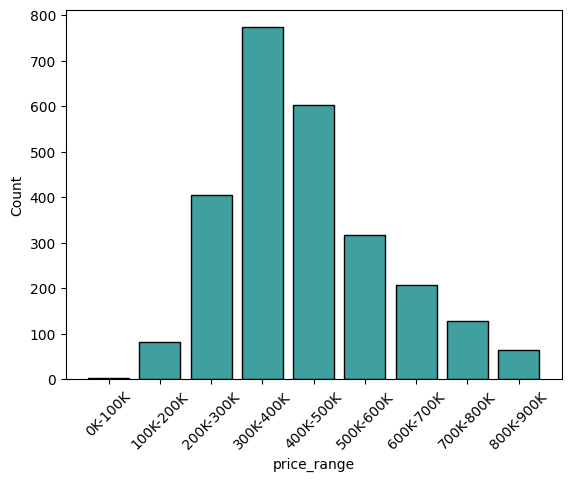

In [758]:
sns.histplot(df_kc_target["price_range"], color = "teal", shrink = 0.8)
plt.xticks(rotation=45)

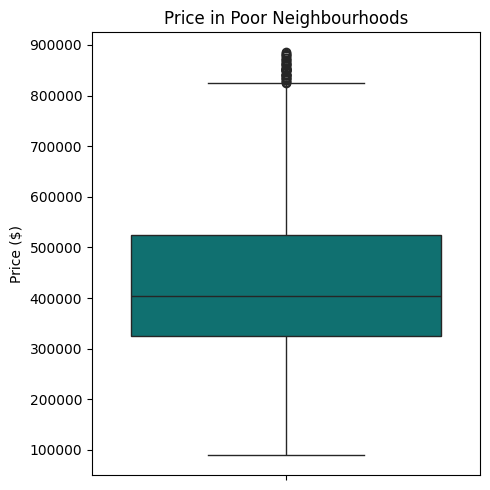

In [759]:
# Create subplots
fig, ax = plt.subplots(figsize=(5, 5))

sns.boxplot(y=df_kc_target["price"], color="teal")

# Set titles
ax.set_title('Price in Poor Neighbourhoods')

# Set y-axis label for both subplots
ax.set_ylabel("Price ($)")

# Adjust layout to make it look nice
plt.ylabel("Price ($)")
plt.tight_layout()

# Show plot
plt.show()

## Evaluate Housing Value

In [760]:
df_kc_target.columns

Index(['house_id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'price_range'],
      dtype='object')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 [Text(0, 0, 'yr_built'),
  Text(1, 0, 'waterfront'),
  Text(2, 0, 'floors'),
  Text(3, 0, 'sqft_lot15'),
  Text(4, 0, 'sqft_lot'),
  Text(5, 0, 'yr_renovated'),
  Text(6, 0, 'condition'),
  Text(7, 0, 'view'),
  Text(8, 0, 'bathrooms'),
  Text(9, 0, 'bedrooms'),
  Text(10, 0, 'sqft_basement'),
  Text(11, 0, 'sqft_living15'),
  Text(12, 0, 'grade'),
  Text(13, 0, 'sqft_above'),
  Text(14, 0, 'sqft_living'),
  Text(15, 0, 'price')])

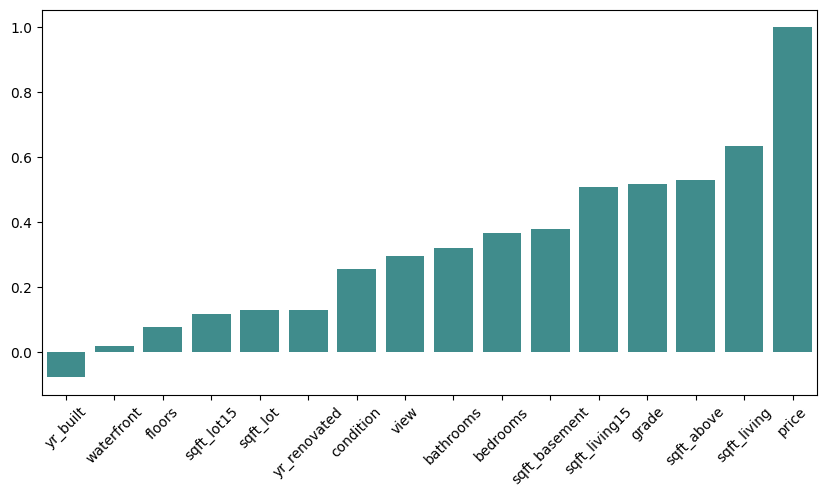

In [781]:
df_kc_target_corr = df_kc_target[['price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'sqft_living15', 'sqft_lot15']].corr()

fig, ax = plt.subplots(figsize = (10,5))
sns.barplot(df_kc_target_corr[["price"]].sort_values(by="price").T, color = "teal", alpha = 0.8)
        

plt.xticks(rotation=45)

In [ ]:
# hightest impact on value (price) --> sqft_living; sqft_above, grade and sqft_living15; 
# Remove waterfront, yr_built, floors, sqft_lot15, sqft_lot, as they don't seem to have influece on pricce in these target neighbourhoods; 
# As the renovation is a relevant feature, I will evaluate it independently. 

df_kc_target = df_kc_target[['house_id', 'date', 'price', 'bedrooms', 'bathrooms', 
                             'sqft_living', 'view', 'condition', 'grade',
                             'sqft_above', 'sqft_basement','lat', 'long', 'sqft_living15', 
                             'yr_renovated']]

In [782]:
df_kc_target_corr = df_kc_target[['bedrooms', 'bathrooms', 'sqft_living', 
                                  'view', 'condition', 'grade', 'sqft_above', 
                                  'sqft_basement', 'sqft_living15', 'price']].corr()

In [783]:
df_kc_target_pairplot = df_kc_target[['bedrooms', 'bathrooms', 'sqft_living', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement',  'sqft_living15',  'price']]

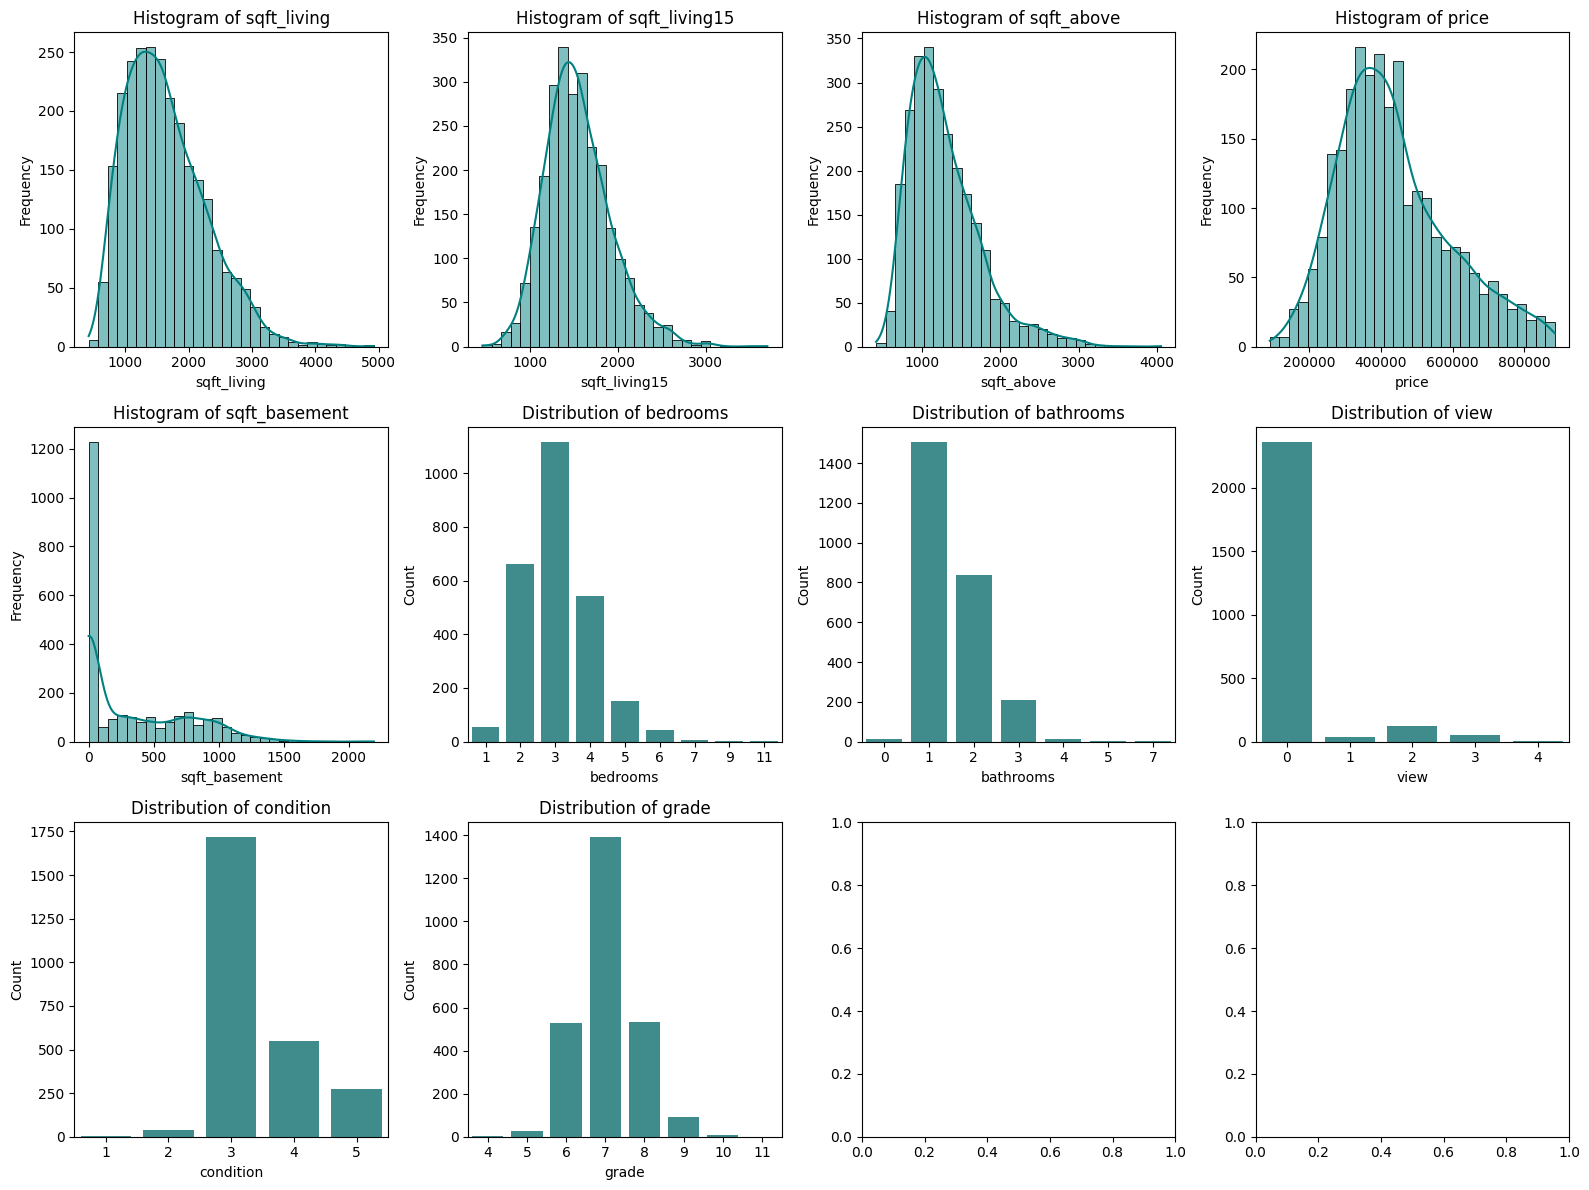

In [793]:
continuous_columns = ['sqft_living', 'sqft_living15', 'sqft_above', 'price', 'sqft_basement']
categorical_columns = ['bedrooms', 'bathrooms', 'view', 'condition', 'grade']

# Set up a grid of subplots (adjust rows and columns as needed)
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 12))  # Adjust grid size based on the number of features
axes = axes.flatten()

# Plot continuous variables (with bins)
for i, feature in enumerate(continuous_columns):
    sns.histplot(df_kc_target[feature], kde=True, ax=axes[i], color='teal', bins=30)  # Adjust bins as needed
    axes[i].set_title(f'Histogram of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

# Plot categorical variables (as bar plots)
for i, feature in enumerate(categorical_columns, start=len(continuous_columns)):
    sns.countplot(data=df_kc_target, x=feature, ax=axes[i], color="teal", alpha = 0.8)
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()



Text(0, 0.5, 'Price ($)')

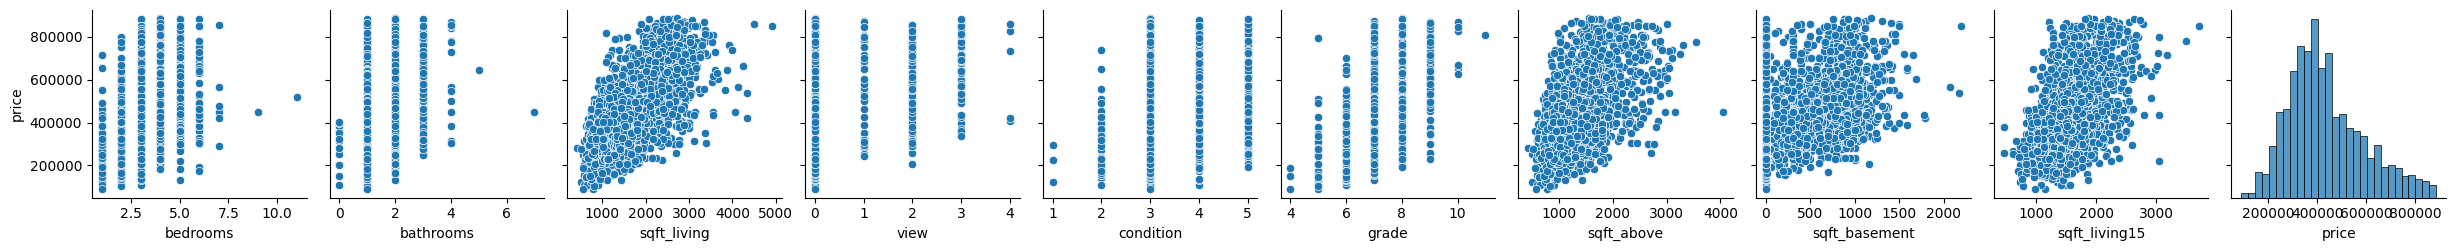

In [796]:
sns.pairplot(df_kc_target_pairplot,
             y_vars=["price"])

plt.ylabel("Price ($)")

In [577]:
df_kc_target["condition"].value_counts()

condition
3    1716
4     550
5     271
2      40
1       3
Name: count, dtype: int64

In [578]:
df_kc_target["grade"].value_counts()

grade
7     1390
8      532
6      528
9       92
5       28
10       6
4        3
11       1
Name: count, dtype: int64

In [579]:
df_kc_target[df_kc_target["yr_renovated"] > 2010]["grade"].value_counts()

grade
7    13
8     8
6     3
9     1
Name: count, dtype: int64

In [580]:
df_kc_target[df_kc_target["yr_renovated"] > 2010]["condition"].value_counts()

condition
3    24
5     1
Name: count, dtype: int64

In [581]:
# Renovated flats seem to have grade = 3; condition = 7

<Axes: xlabel='grade', ylabel='price'>

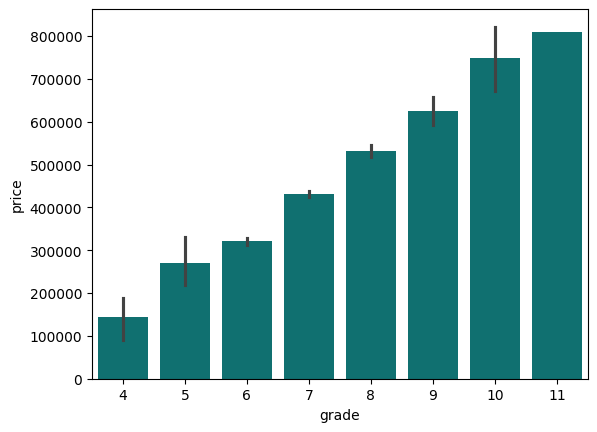

In [582]:
sns.barplot(df_kc_target, x = df_kc_target["grade"], y = df_kc_target["price"], color ="teal")

<Axes: xlabel='grade', ylabel='Count'>

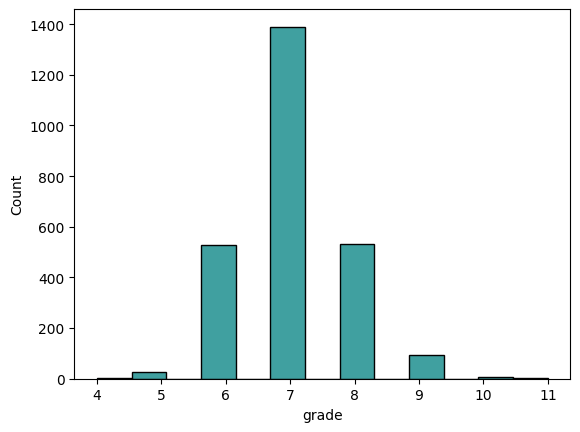

In [583]:
sns.histplot(df_kc_target["grade"], color="teal", shrink=1)

<Axes: xlabel='condition', ylabel='price'>

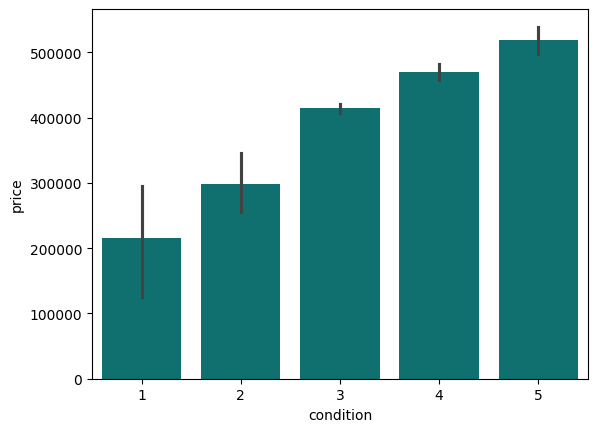

In [584]:
sns.barplot(df_kc_target, x = df_kc_target["condition"], y = df_kc_target["price"], color ="teal")

<Axes: xlabel='condition', ylabel='Count'>

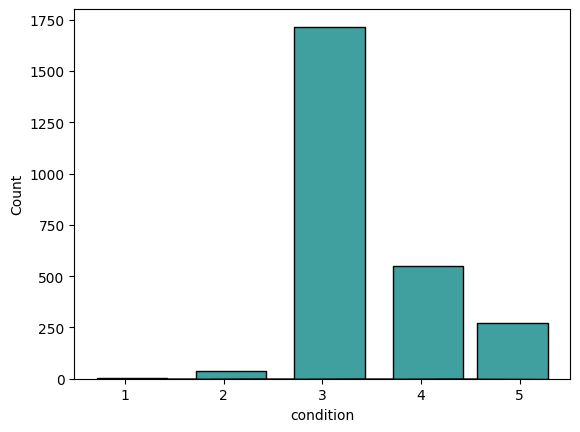

In [585]:
sns.histplot(df_kc_target["condition"], color="teal", shrink=5)

In [586]:
## Due to lack of proper data distribution, I get rid of the condition feature
df_kc_target = df_kc_target.drop("condition", axis = 1)

In [587]:
df_kc_target_pairplot = df_kc_target[['bedrooms', 'bathrooms', 'sqft_living', 'view', 'grade', 'sqft_above', 'sqft_basement',  'sqft_living15',  'price']]

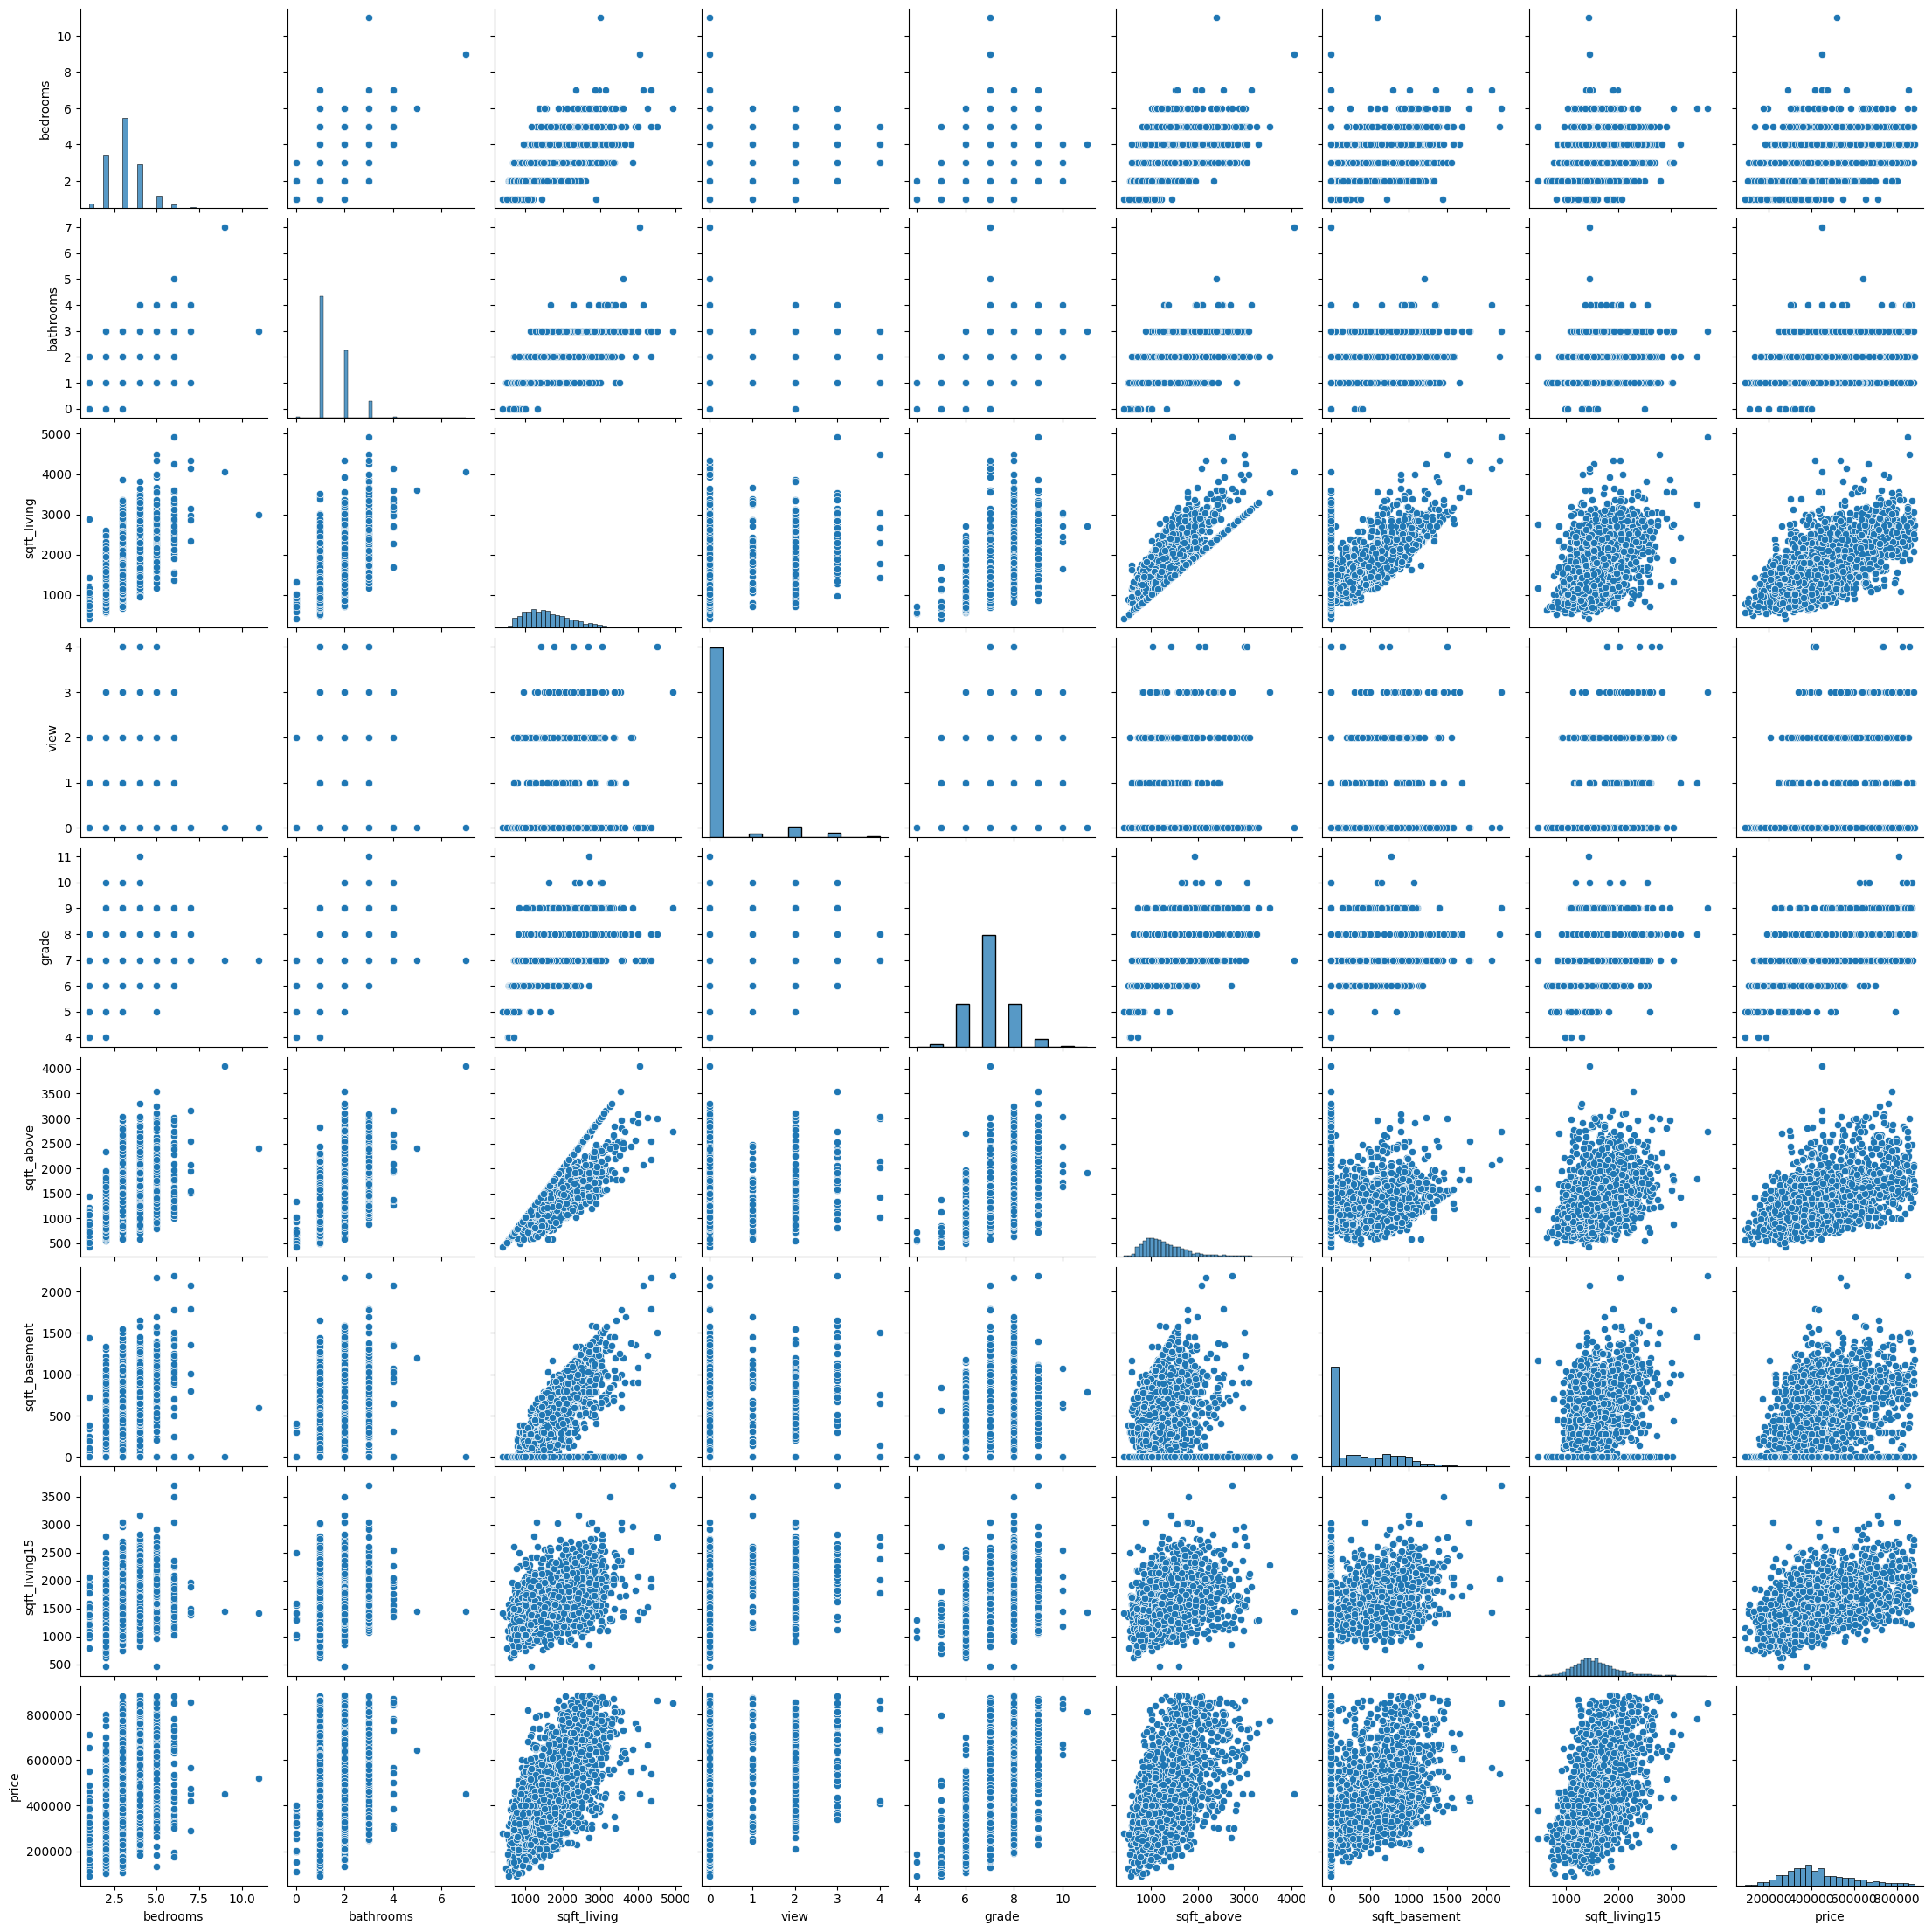

In [588]:
sns.pairplot(df_kc_target_pairplot)

In [589]:
# we leave the view out, as it doesnt influence that much on price, and distribution is not good

df_kc_target = df_kc_target.drop("view", axis=1)

## Strategy 1: Identify undervalued properties to renovate in target area

In [590]:
df_kc_target_potential = df_kc_target.query("yr_renovated == 0")

In [591]:
df_kc_target.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2580 entries, 1 to 21596
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   house_id       2580 non-null   int64         
 1   date           2580 non-null   datetime64[ns]
 2   price          2580 non-null   float64       
 3   bedrooms       2580 non-null   int64         
 4   bathrooms      2580 non-null   int64         
 5   sqft_living    2580 non-null   float64       
 6   grade          2580 non-null   int64         
 7   sqft_above     2580 non-null   float64       
 8   sqft_basement  2580 non-null   int64         
 9   zipcode        2580 non-null   int64         
 10  lat            2580 non-null   float64       
 11  long           2580 non-null   float64       
 12  sqft_living15  2580 non-null   float64       
 13  yr_renovated   2580 non-null   int64         
 14  price_range    2580 non-null   category      
dtypes: category(1), datetime6

In [592]:
df_kc_target_potential = df_kc_target_potential.query("grade <= 5 and bathrooms > 0")

In [593]:
df_kc_potential_pairplot = df_kc_target_potential[['bedrooms', 'bathrooms', 'sqft_living', 'grade', 'sqft_above', 'sqft_basement',  'sqft_living15',  'price']]

### Option 1: take a bigger flat

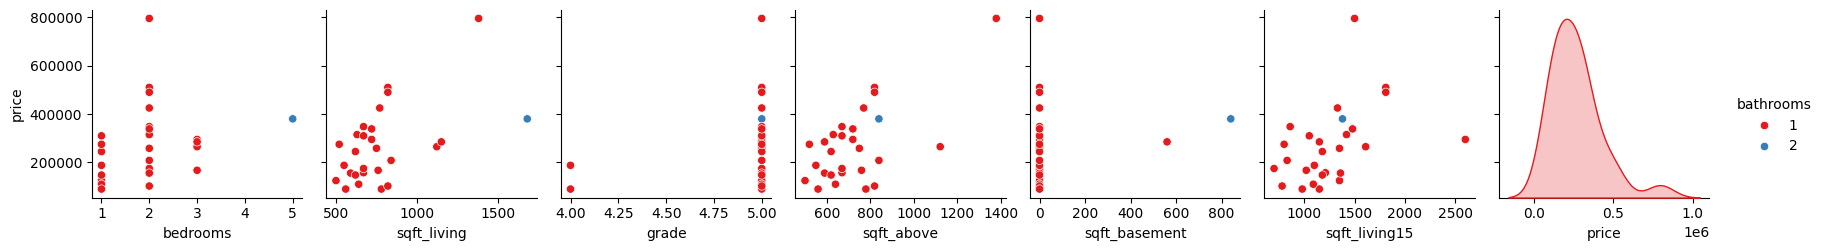

In [594]:
sns.pairplot(df_kc_potential_pairplot, 
             hue="bathrooms", 
             palette="Set1", 
             y_vars=["price"])


In [595]:
df_kc_target_potential[df_kc_target_potential["bathrooms"]==2] # --> house ID: 3320000810

house_id       date     price  bedrooms  bathrooms  sqft_living  \
1140  3320000810 2015-02-24  380000.0         5          2       1680.0   

      grade  sqft_above  sqft_basement  zipcode      lat     long  \
1140      5       840.0            840    98144  47.5965 -122.311   

      sqft_living15  yr_renovated price_range  
1140         1380.0             0   300K-400K

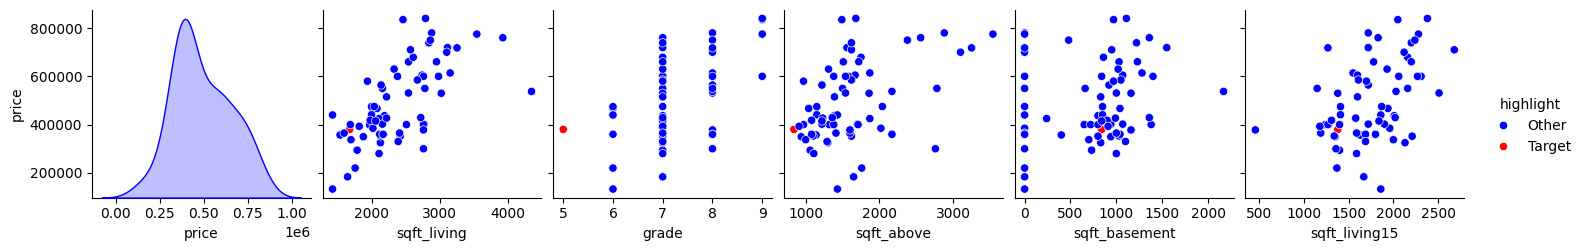

In [596]:
# Create a new column to differentiate the target house from the others
df_kc_target["highlight"] = df_kc_target["house_id"].apply(
    lambda x: "Target" if x == 3320000810 else "Other"
)

# Plot with the new highlight column as hue
sns.pairplot(df_kc_target.query("bathrooms == 2 and bedrooms == 5").drop(["house_id", "bedrooms", "bathrooms","yr_renovated", "zipcode", "lat", "long"], axis=1),  
             palette={"Target": "red", "Other": "blue"},  # Custom colors
             hue="highlight", 
             y_vars=["price"])


In [597]:
df_kc_target.query("bathrooms == 2 and bedrooms == 5").describe()

house_id                           date          price  bedrooms  \
count  6.800000e+01                             68      68.000000      68.0   
mean   4.514505e+09  2014-10-20 02:49:24.705882368  490148.970588       5.0   
min    2.350001e+08            2014-05-07 00:00:00  133000.000000       5.0   
25%    2.608320e+09            2014-07-28 00:00:00  365000.000000       5.0   
50%    3.970950e+09            2014-10-18 00:00:00  438500.000000       5.0   
75%    5.974526e+09            2014-12-29 00:00:00  601250.000000       5.0   
max    9.842300e+09            2015-05-14 00:00:00  840000.000000       5.0   
std    2.514356e+09                            NaN  163489.319777       0.0   

       bathrooms  sqft_living      grade   sqft_above  sqft_basement  \
count       68.0    68.000000  68.000000    68.000000      68.000000   
mean         2.0  2392.647059   7.205882  1621.764706     750.588235   
min          2.0  1430.000000   5.000000   840.000000       0.000000   
25%          2.0  2015.000000   7.000000  1220.000000     360.000000   
50%          2.0  2275.000000   7.000000  1525.000000     855.000000   
75%          2.0  2760.000000   8.000000  1752.500000    1040.000000   
max          2.0  4340.000000   9.000000  3540.000000    2170.000000   
std          0.0   567.583560   0.764098   578.969597     493.515813   

            zipcode        lat        long  sqft_living15  yr_renovated  
count     68.000000  68.000000   68.000000      68.000000     68.000000  
mean   98122.014706  47.588104 -122.305147    1742.647059    117.191176  
min    98106.000000  47.514900 -122.381000     460.000000      0.000000  
25%    98115.000000  47.530850 -122.311000    1407.500000      0.000000  
50%    98118.000000  47.560400 -122.297500    1720.000000      0.000000  
75%    98126.000000  47.616650 -122.282000    2022.500000      0.000000  
max    98144.000000  47.725500 -122.263000    2680.000000   2004.000000  
std       13.174481   0.069381    0.031062     391.261327    472.256136

In [598]:
df_2_5_seelction = df_kc_target.query("bathrooms == 2 and bedrooms == 5")

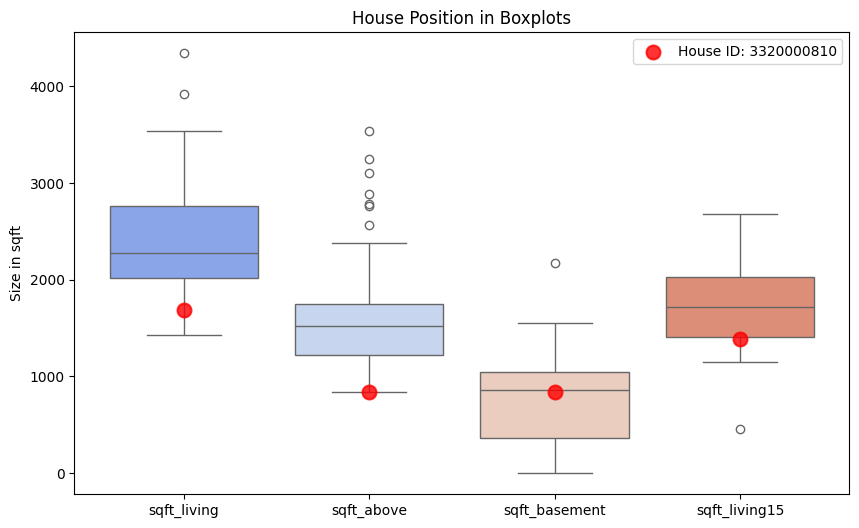

In [599]:
# Define house ID
house_id = 3320000810

# Extract house values
house_values = df_2_5_seelction[df_2_5_seelction["house_id"] == house_id][["sqft_living", "sqft_above", "sqft_basement", "sqft_living15"]]

# Create boxplot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df_2_5_seelction[["sqft_living", "sqft_above", "sqft_basement", "sqft_living15"]], palette="coolwarm")

# Overlay red scatter points for the specific house
for i, col in enumerate(house_values.columns):
    y_value = house_values[col].values[0]
    plt.scatter(i, y_value + 1,  # Small vertical offset to avoid overlap
                color="red", s=100, alpha=0.8,  linewidth=1.5, zorder=3, 
                label="House ID: 3320000810" if i == 0 else "")

# Improve visualization
plt.xticks(ticks=range(len(house_values.columns)), labels=house_values.columns)
plt.ylabel("Size in sqft")
plt.title("House Position in Boxplots")
plt.legend()
plt.show()


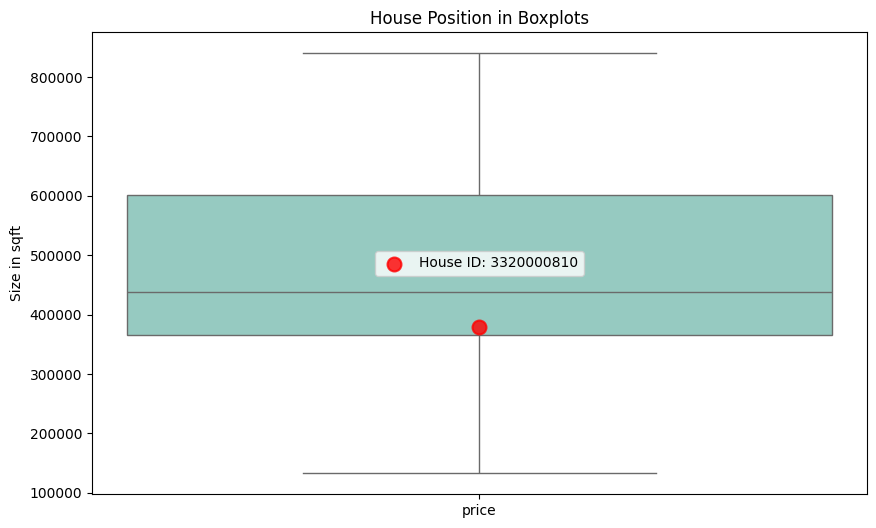

In [600]:
# Define house ID
house_id = 3320000810

# Extract house values
house_values = df_2_5_seelction[df_2_5_seelction["house_id"] == house_id][["price"]]

# Create boxplot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df_2_5_seelction[["price"]], palette="Set3")

# Overlay red scatter points for the specific house
for i, col in enumerate(house_values.columns):
    y_value = house_values[col].values[0]
    plt.scatter(i, y_value + 1,  # Small vertical offset to avoid overlap
                color="red", s=100, alpha=0.8,  linewidth=1.5, zorder=3, 
                label="House ID: 3320000810" if i == 0 else "")

# Improve visualization
plt.xticks(ticks=range(len(house_values.columns)), labels=house_values.columns)
plt.ylabel("Size in sqft")
plt.title("House Position in Boxplots")
plt.legend()
plt.show()

C:\Users\Marina\AppData\Local\Temp\ipykernel_20380\2477075818.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=df_2_5_seelction, x="grade", y="price", palette="Set3")


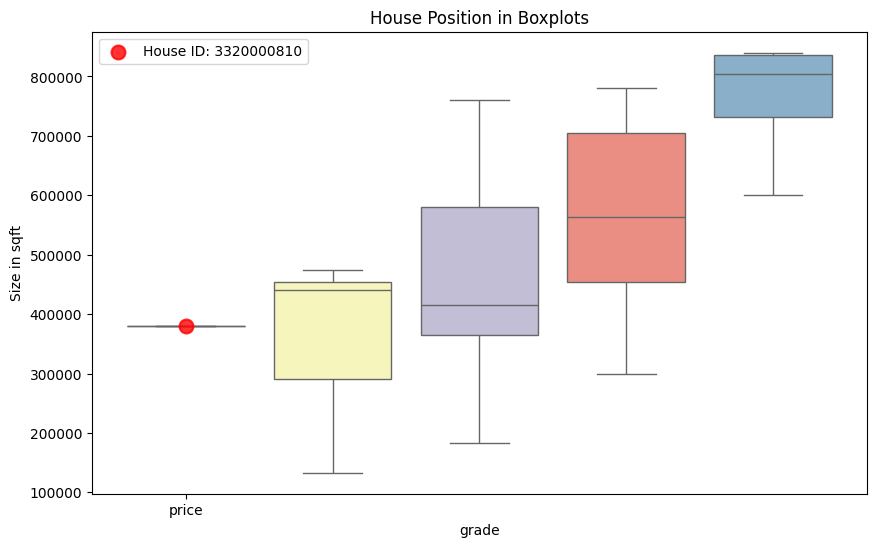

In [601]:
# Define house ID
house_id = 3320000810

# Extract house values
house_values = df_2_5_seelction[df_2_5_seelction["house_id"] == house_id][["price"]]

# Create boxplot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df_2_5_seelction, x="grade", y="price", palette="Set3")

# Overlay red scatter points for the specific house
for i, col in enumerate(house_values.columns):
    y_value = house_values[col].values[0]
    plt.scatter(i, y_value + 1,  # Small vertical offset to avoid overlap
                color="red", s=100, alpha=0.8,  linewidth=1.5, zorder=3, 
                label="House ID: 3320000810" if i == 0 else "")

# Improve visualization
plt.xticks(ticks=range(len(house_values.columns)), labels=house_values.columns)
plt.ylabel("Size in sqft")
plt.title("House Position in Boxplots")
plt.legend()
plt.show()

### Option 2: Smaller flats

In [602]:
df_kc_target_potential = df_kc_target_potential.query("grade <= 5 and bathrooms == 1")

In [603]:
df_kc_potential_pairplot = df_kc_target_potential[['bedrooms', 'sqft_living', 'grade', 'sqft_above', 'sqft_basement',  'sqft_living15',  'price']]

In [604]:
df_kc_target_potential.query("sqft_basement > 0") # --> House ID 5652601035

house_id       date     price  bedrooms  bathrooms  sqft_living  \
8926  5652601035 2015-01-15  285000.0         3          1       1150.0   

      grade  sqft_above  sqft_basement  zipcode      lat     long  \
8926      5       590.0            560    98115  47.6973 -122.297   

      sqft_living15  yr_renovated price_range  
8926         1150.0             0   200K-300K

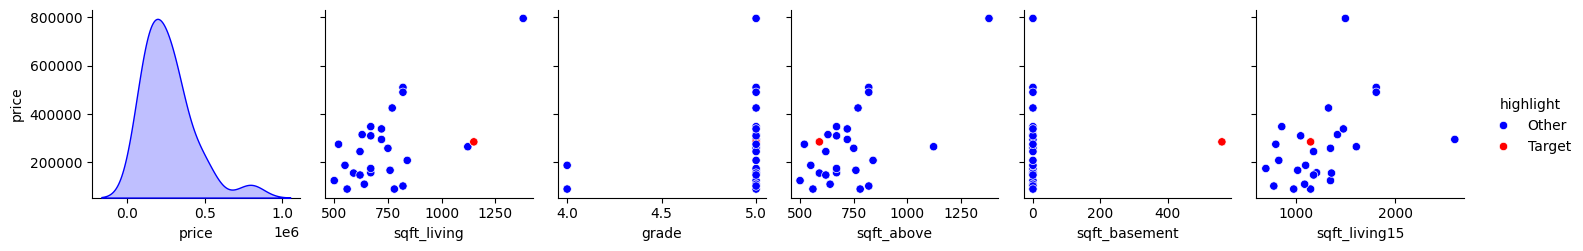

In [605]:
# Create a new column to differentiate the target house from the others
df_kc_target["highlight"] = df_kc_target["house_id"].apply(
    lambda x: "Target" if x == 5652601035 else "Other"
)

# Plot with the new highlight column as hue
sns.pairplot(df_kc_target.query("grade <= 5 and bathrooms == 1").drop(["house_id", "bedrooms", "bathrooms","yr_renovated", "zipcode", "lat", "long"], axis=1),  
             palette={"Target": "red", "Other": "blue"},  # Custom colors
             hue="highlight", 
             y_vars=["price"])

In [606]:
df_basement_selection = df_kc_target.query("bedrooms == 3 and bathrooms == 1")

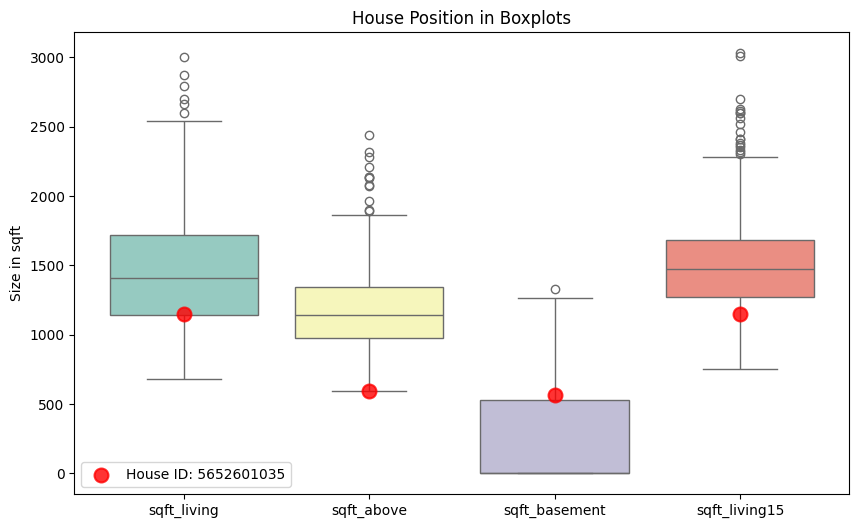

In [607]:
# Define house ID
house_id = 5652601035

# Extract house values
house_values = df_basement_selection[df_basement_selection["house_id"] == house_id][["sqft_living", "sqft_above", "sqft_basement", "sqft_living15"]]

# Create boxplot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df_basement_selection[["sqft_living", "sqft_above", "sqft_basement", "sqft_living15"]], palette="Set3")

# Overlay red scatter points for the specific house
for i, col in enumerate(house_values.columns):
    y_value = house_values[col].values[0]
    plt.scatter(i, y_value + 1,  # Small vertical offset to avoid overlap
                color="red", s=100, alpha=0.8,  linewidth=1.5, zorder=3, 
                label="House ID: 5652601035" if i == 0 else "")

# Improve visualization
plt.xticks(ticks=range(len(house_values.columns)), labels=house_values.columns)
plt.ylabel("Size in sqft")
plt.title("House Position in Boxplots")
plt.legend()
plt.show()


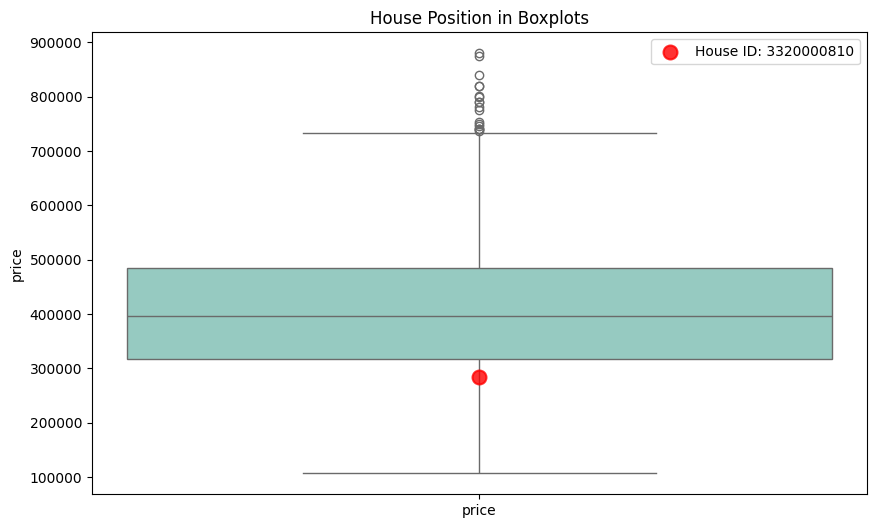

In [608]:
# Define house ID
house_id = 5652601035

# Extract house values
house_values = df_basement_selection[df_basement_selection["house_id"] == house_id][["price"]]

# Create boxplot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df_basement_selection[["price"]], palette="Set3")

# Overlay red scatter points for the specific house
for i, col in enumerate(house_values.columns):
    y_value = house_values[col].values[0]
    plt.scatter(i, y_value + 1,  # Small vertical offset to avoid overlap
                color="red", s=100, alpha=0.8,  linewidth=1.5, zorder=3, 
                label="House ID: 3320000810" if i == 0 else "")

# Improve visualization
plt.xticks(ticks=range(len(house_values.columns)), labels=house_values.columns)
plt.ylabel("price")
plt.title("House Position in Boxplots")
plt.legend()
plt.show()

### Option 3: ,,

In [610]:
df_kc_target_potential = df_kc_target_potential.query("grade == 5 and bathrooms > 0")

## grade = 4 are too small so not much potential. Removed. Also dropped price outlier. Sqft more than 800 https://www.apartments.com/blog/how-much-square-footage-do-i-need

In [611]:
df_kc_potential_pairplot = df_kc_target_potential[['bedrooms', 'sqft_living', 'sqft_above',  'sqft_living15',  'price']]

In [613]:
# df_kc_target_potential # --> House ID 7129302095 and 5652601035

C:\Users\Marina\AppData\Local\Temp\ipykernel_20380\364634899.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=df_kc_target_potential,  y="price", palette="Set3")


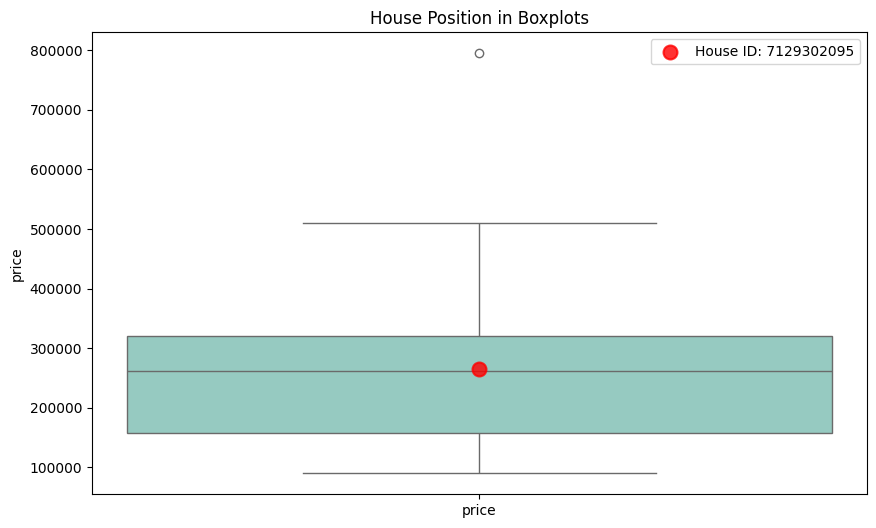

In [615]:
# Define house ID
house_id = 7129302095

# Extract house values
house_values = df_kc_target_potential[df_kc_target_potential["house_id"] == house_id][["price"]]

# Create boxplot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df_kc_target_potential,  y="price", palette="Set3")

# Overlay red scatter points for the specific house
for i, col in enumerate(house_values.columns):
    y_value = house_values[col].values[0]
    plt.scatter(i, y_value + 1,  # Small vertical offset to avoid overlap
                color="red", s=100, alpha=0.8,  linewidth=1.5, zorder=3, 
                label="House ID: 7129302095" if i == 0 else "")

# Improve visualization
plt.xticks(ticks=range(len(house_values.columns)), labels=house_values.columns)
plt.ylabel("price")
plt.title("House Position in Boxplots")
plt.legend()
plt.show()

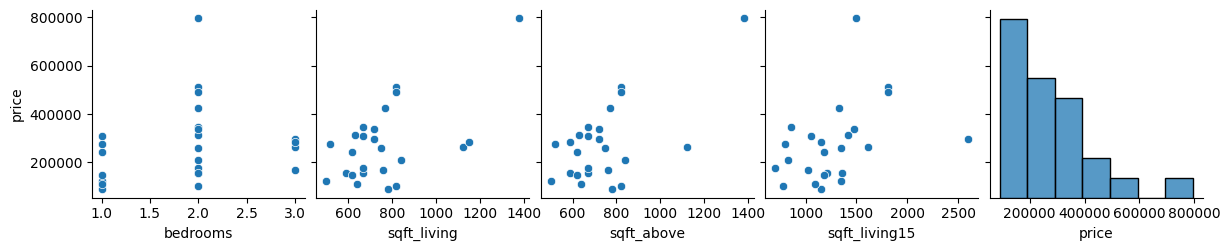

In [616]:
sns.pairplot(df_kc_potential_pairplot, 
             y_vars=["price"])


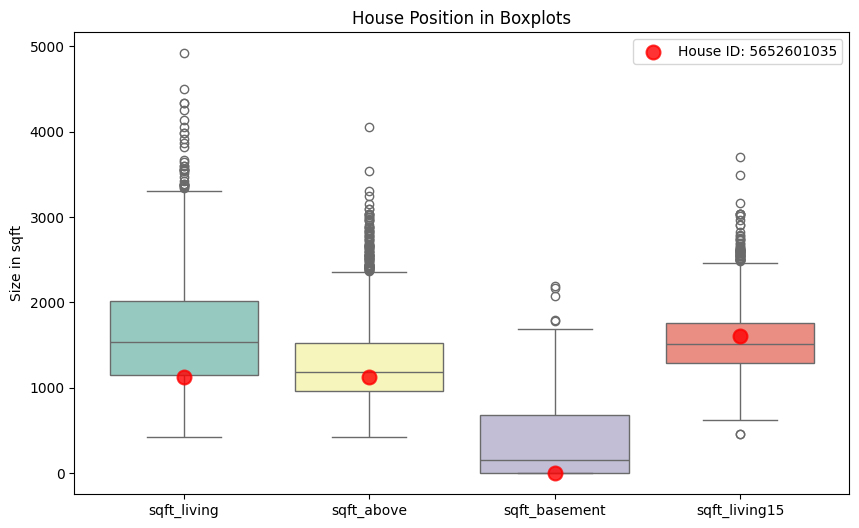

In [618]:
# Define house ID
house_id = 7129302095

# Extract house values
house_values = df_kc_target[df_kc_target["house_id"] == house_id][["sqft_living", "sqft_above", "sqft_basement", "sqft_living15"]]

# Create boxplot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df_kc_target[["sqft_living", "sqft_above", "sqft_basement", "sqft_living15"]], palette="Set3")

# Overlay red scatter points for the specific house
for i, col in enumerate(house_values.columns):
    y_value = house_values[col].values[0]
    plt.scatter(i, y_value + 1,  # Small vertical offset to avoid overlap
                color="red", s=100, alpha=0.8,  linewidth=1.5, zorder=3, 
                label="House ID: 5652601035" if i == 0 else "")

# Improve visualization
plt.xticks(ticks=range(len(house_values.columns)), labels=house_values.columns)
plt.ylabel("Size in sqft")
plt.title("House Position in Boxplots")
plt.legend()
plt.show()

C:\Users\Marina\AppData\Local\Temp\ipykernel_20380\3787129465.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=df_kc_target, x="grade", y="price", palette="Set3")


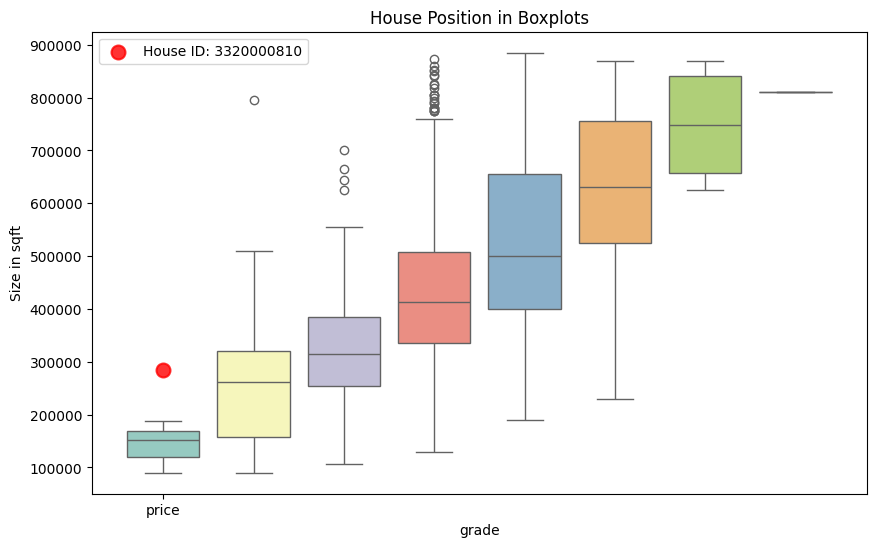

In [620]:
# Define house ID
house_id = 5652601035

# Extract house values
house_values = df_kc_target[df_kc_target["house_id"] == house_id][["price"]]

# Create boxplot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df_kc_target, x="grade", y="price", palette="Set3")

# Overlay red scatter points for the specific house
for i, col in enumerate(house_values.columns):
    y_value = house_values[col].values[0]
    plt.scatter(i, y_value + 1,  # Small vertical offset to avoid overlap
                color="red", s=100, alpha=0.8,  linewidth=1.5, zorder=3, 
                label="House ID: 3320000810" if i == 0 else "")

# Improve visualization
plt.xticks(ticks=range(len(house_values.columns)), labels=house_values.columns)
plt.ylabel("Size in sqft")
plt.title("House Position in Boxplots")
plt.legend()
plt.show()

# Next Section

In [27]:
fig = px.scatter_mapbox(df_kc_target, 
                        lat="lat", 
                        lon="long", 
                        color= "price_range",  # Color by price range
                        hover_name= "price",  # Show price in hover info
                        color_discrete_sequence=["blue", "green", "orange", "red"], 
                        title="House Prices in King County", 
                        mapbox_style= "carto-positron", 
                        zoom=10)

# Show the plot
fig.show()

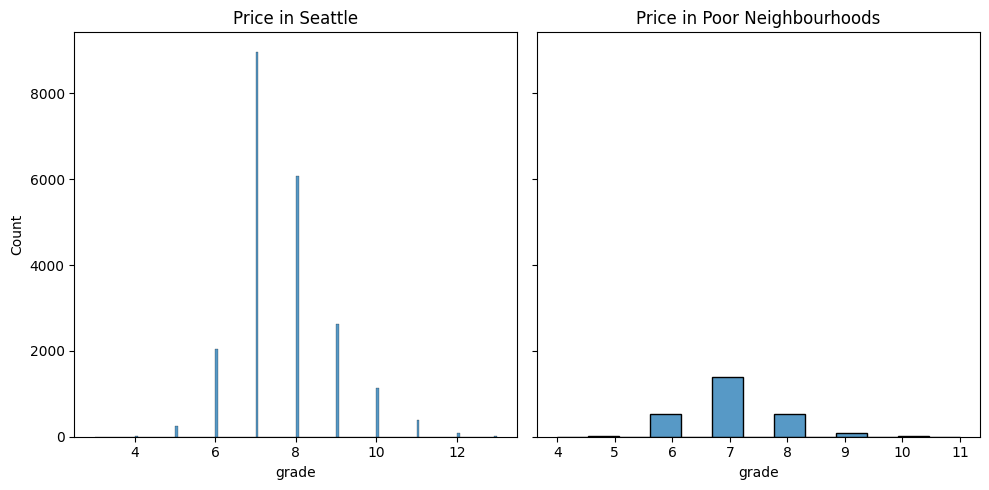

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

sns.histplot(df_kc_data["grade"], ax=ax[0])

sns.histplot(df_kc_target["grade"], ax=ax[1])

ax[0].set_title('Price in Seattle')
ax[1].set_title('Price in Poor Neighbourhoods')

plt.tight_layout() 
plt.show()


#lower grades are more common in poor neighbourhoods

<Axes: xlabel='price', ylabel='yr_renovated'>

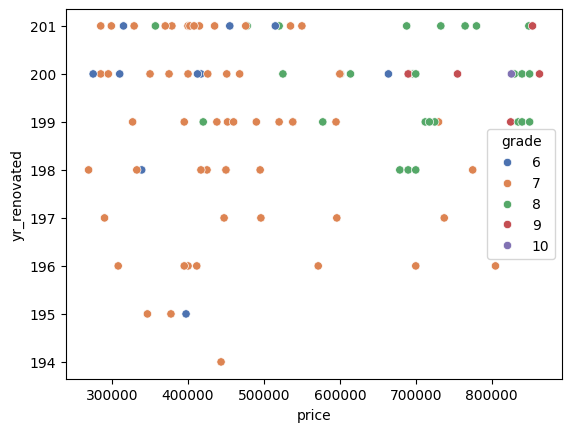

In [29]:
sns.scatterplot(df_kc_target.query("yr_renovated > 0"), x="price", y="yr_renovated", hue="grade", palette="deep" )

<Axes: xlabel='yr_built', ylabel='price'>

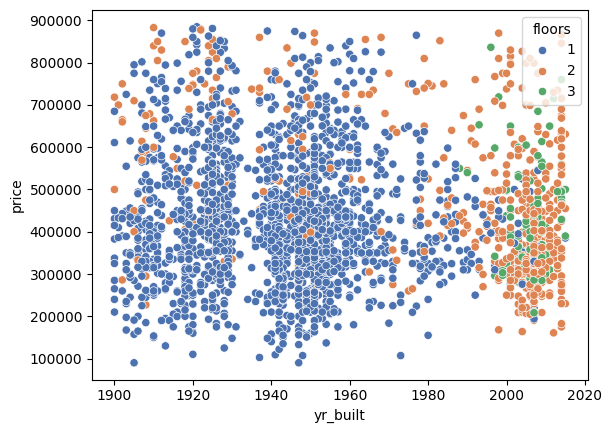

In [30]:
sns.scatterplot(df_kc_target, y="price", x="yr_built", hue="floors", palette="deep" )

<Axes: xlabel='condition', ylabel='Count'>

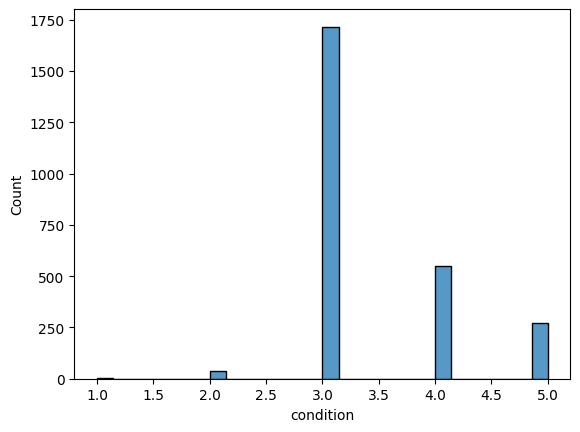

In [31]:
sns.histplot(df_kc_target["condition"])

In [32]:
df_kc_target.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2580 entries, 1 to 21596
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   house_id       2580 non-null   int64         
 1   date           2580 non-null   datetime64[ns]
 2   price          2580 non-null   float64       
 3   bedrooms       2580 non-null   int64         
 4   bathrooms      2580 non-null   int64         
 5   sqft_living    2580 non-null   float64       
 6   sqft_lot       2580 non-null   float64       
 7   floors         2580 non-null   int64         
 8   waterfront     2580 non-null   int64         
 9   view           2580 non-null   int64         
 10  condition      2580 non-null   int64         
 11  grade          2580 non-null   int64         
 12  sqft_above     2580 non-null   float64       
 13  sqft_basement  2580 non-null   int64         
 14  yr_built       2580 non-null   int64         
 15  yr_renovated   2580 non-n

In [99]:
df_kc_target.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2717 entries, 1 to 21596
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   house_id       2717 non-null   int64   
 1   date           2717 non-null   object  
 2   price          2717 non-null   float64 
 3   bedrooms       2717 non-null   float64 
 4   bathrooms      2717 non-null   float64 
 5   sqft_living    2717 non-null   float64 
 6   sqft_lot       2717 non-null   float64 
 7   floors         2717 non-null   float64 
 8   waterfront     2406 non-null   float64 
 9   view           2707 non-null   float64 
 10  condition      2717 non-null   int64   
 11  grade          2717 non-null   int64   
 12  sqft_above     2717 non-null   float64 
 13  sqft_basement  2661 non-null   float64 
 14  yr_built       2717 non-null   int64   
 15  yr_renovated   2205 non-null   float64 
 16  zipcode        2717 non-null   int64   
 17  lat            2717 non-null   float6